In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import rdkit.Chem as Chem
import openbabel as ob
import os
import glob
from src.utils.chem import rmsd
# import pearson
from scipy.stats import pearsonr

from copy import deepcopy
from rdkit.Chem import Descriptors


In [3]:
DOCKING_DIR = '/home/cch57/projects/poses_benchmark/data/docking_results'

models = os.listdir(DOCKING_DIR)
dfs = []

for model in models:
    
    docking_files = glob.glob(os.path.join(DOCKING_DIR, model, '*.pt'))
    data = [torch.load(f) for f in docking_files]
    
    for i, target in enumerate(data):
        for j, score in enumerate(target['raw']):
            try:
                if len(data[i]['raw'][j]['redocked']['mols']) == 0:
                    data[i]['raw'][j]['redocked']['mols'] = [None] * 8 
            except:
                print('hit None - skipping')
    
    df = pd.DataFrame({
            'generated': [score['raw'][index]['score_only']['affinity'] for score in data for index in range(len(score['raw'])) if score['raw'][index]['score_only'] is not None],
            'minimized' : [score['raw'][index]['minimized']['min_affinity'] for score in data for index in range(len(score['raw'])) if score['raw'][index]['score_only'] is not None],
            'redocked_best' : [score['raw'][index]['redocked']['affinities'][0] for score in data for index in range(len(score['raw'])) if score['raw'][index]['score_only'] is not None],
            'redocked_all' : [score['raw'][index]['redocked']['affinities'] for score in data for index in range(len(score['raw'])) if score['raw'][index]['score_only'] is not None],
            
            # mols
            'generated_mol': [score['raw'][index]['score_only']['mol'] for score in data for index in range(len(score['raw'])) if score['raw'][index]['score_only'] is not None],
            'minimized_mol' : [score['raw'][index]['minimized']['mol'] for score in data for index in range(len(score['raw'])) if score['raw'][index]['score_only'] is not None],
            'redocked_best_mol' : [score['raw'][index]['redocked']['mols'][0] for score in data for index in range(len(score['raw'])) if score['raw'][index]['score_only'] is not None],
            'redocked_all_mol' : [score['raw'][index]['redocked']['mols'] for score in data for index in range(len(score['raw'])) if score['raw'][index]['score_only'] is not None],
            # rmsds
            'min_rmsd' : [score['raw'][index]['minimized']['min_rmsd'] for score in data for index in range(len(score['raw'])) if score['raw'][index]['score_only'] is not None],
            
            # relaxed
            #'relaxed_generated' : [score['relaxed'][0]['score_only']['affinity'] for score in data],
            #'relaxed_minimized' : [score['relaxed'][0]['minimized']['min_affinity'] for score in data],
            #'relaxed_redocked_best' : [score['relaxed'][index]['redocked']['affinities'][0] for score in data for index in range(len(score['relaxed']))],
            #'relaxed_redocked_all' : [score['relaxed'][index]['redocked']['affinities'] for score in data for index in range(len(score['relaxed']))],
            'target': [score['receptor_path'].split('/')[-1].split('.')[0][:4] for score in data for _ in range(len(score['raw'])) if score['raw'][_]['score_only'] is not None]
            })

    df['method'] = model
    
    redocked_rmsds = []
    for i, row in df.iterrows():
        
        generated = row['generated_mol']
        redocked = row['redocked_best_mol']
        
        redocked_rmsd = rmsd(generated, redocked)
        redocked_rmsds.append(redocked_rmsd)
    
    df['redock_rmsd'] = redocked_rmsds
    
    df['mw'] = [Descriptors.MolWt(mol) if mol is not None else None for mol in df.generated_mol]
    
    dfs.append(df)
    
df = pd.concat(dfs)

In [ ]:
names_dict = {'crossdocked_test': 'CrossDocked',
              'ar': '3DSBDD',
              'pocket2mol': 'Pocket2Mol',
              'targetdiff': 'TargetDiff',
              'diffsbdd': 'DiffSBDD',
              'cvae': 'LiGAN',
              'decompdiff': 'DecompDiff',
              'flag': 'FLAG',}

def order_to_name(order):
    names = []
    for o in order:
        names.append(names_dict[o])
    return names

In [ ]:
df.head()

,generated,minimized,redocked_best,redocked_all,generated_mol,minimized_mol,redocked_best_mol,redocked_all_mol,min_rmsd,target,method,redock_rmsd,mw
0,-2.14308,-2.59421,-2.9,"[-2.9, -2.9, -2.8, -2.7, -2.7, -2.7, -2.6, -2....",<rdkit.Chem.rdchem.Mol object at 0x2b6a92380a40>,<rdkit.Chem.rdchem.Mol object at 0x2b6a92380ae0>,<rdkit.Chem.rdchem.Mol object at 0x2b6a92380b30>,[<rdkit.Chem.rdchem.Mol object at 0x2b6a92380b...,2.24844,2e24,ar,2.161890,86.090
1,-3.12254,-3.36024,-3.5,"[-3.5, -3.3, -3.3, -3.3, -3.2, -3.2, -3.2, -3....",<rdkit.Chem.rdchem.Mol object at 0x2b6a923810d0>,<rdkit.Chem.rdchem.Mol object at 0x2b6a92381170>,<rdkit.Chem.rdchem.Mol object at 0x2b6a923811c0>,[<rdkit.Chem.rdchem.Mol object at 0x2b6a923811...,0.49183,2e24,ar,1.999054,86.134
2,-2.12935,-2.19994,-2.9,"[-2.9, -2.8, -2.8, -2.8, -2.7, -2.7, -2.7, -2....",<rdkit.Chem.rdchem.Mol object at 0x2b6a92381710>,<rdkit.Chem.rdchem.Mol object at 0x2b6a923817b0>,<rdkit.Chem.rdchem.Mol object at 0x2b6a92381850>,[<rdkit.Chem.rdchem.Mol object at 0x2b6a923818...,0.22356,2e24,ar,2.578173,88.106
3,-2.51772,-2.84351,-3.3,"[-3.3, -3.2, -3.1, -3.1, -3.0, -3.0, -3.0, -2....",<rdkit.Chem.rdchem.Mol object at 0x2b6a92381da0>,<rdkit.Chem.rdchem.Mol object at 0x2b6a92381e40>,<rdkit.Chem.rdchem.Mol object at 0x2b6a92381ee0>,[<rdkit.Chem.rdchem.Mol object at 0x2b6a92381e...,0.65768,2e24,ar,2.559881,104.149
4,-3.59638,-4.08889,-4.1,"[-4.1, -4.1, -4.1, -3.7, -3.7, -3.7, -3.6, -3....",<rdkit.Chem.rdchem.Mol object at 0x2b6a92382480>,<rdkit.Chem.rdchem.Mol object at 0x2b6a92382520>,<rdkit.Chem.rdchem.Mol object at 0x2b6a92382570>,[<rdkit.Chem.rdchem.Mol object at 0x2b6a923825...,0.85446,2e24,ar,0.698477,98.145


In [ ]:
df.describe()

,generated,minimized,redocked_best,min_rmsd,redock_rmsd,mw
count,66361.000000,66361.000000,66361.000000,66361.000000,62412.000000,62435.000000
mean,11.558064,-4.441540,-6.732864,1.498799,2.994426,295.114166
std,51.590038,9.200253,2.823331,1.305245,8.568577,128.023445
min,-19.436650,-22.428700,-20.400000,0.000000,0.046697,26.038000
25%,-6.284910,-7.529750,-8.300000,0.657570,1.537753,192.133000
50%,-4.071870,-5.540160,-6.600000,1.053980,2.790012,278.692000
75%,-1.815810,-3.850450,-5.100000,1.803890,3.898775,386.492000
max,614.103030,170.138000,67.700000,10.719540,750.831116,1067.332000


In [ ]:
df.groupby('method').describe()['generated']

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
ar,9295.0,-5.042779,2.580771,-19.19150,-6.668555,-4.682550,-3.122480,20.64391
crossdocked_test,100.0,-5.495190,2.856578,-14.96350,-6.946112,-5.412915,-3.765580,4.18797
cvae,9910.0,-5.998812,2.834306,-19.43665,-7.699813,-5.774070,-3.856208,4.42781
decompdiff,8299.0,-4.318985,3.077416,-18.61222,-5.829440,-4.281280,-2.903780,50.59762
diffsbdd,9057.0,-1.936817,10.308129,-15.64455,-6.034310,-4.240020,-2.228960,122.82726
flag,10833.0,94.201958,89.461104,-4.31590,26.049830,69.574640,134.760960,614.10303
pocket2mol,9831.0,-4.553523,3.176910,-17.96401,-6.378260,-4.123890,-2.640620,31.54241
targetdiff,9036.0,-5.363437,3.788081,-18.54729,-7.428002,-5.461430,-3.495070,52.55846


In [ ]:
df.groupby('method').describe()['redocked_best']

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
ar,9295.0,-6.289059,2.216413,-20.4,-7.7,-6.0,-4.6,-1.1
crossdocked_test,100.0,-6.864000,2.369142,-15.3,-8.1,-6.8,-5.3,-2.6
cvae,9910.0,-7.355156,2.608992,-17.6,-9.2,-7.2,-5.3,-1.4
decompdiff,8299.0,-6.603627,2.118886,-19.2,-8.0,-6.5,-5.2,-2.4
diffsbdd,9057.0,-7.004151,2.014355,-17.2,-8.3,-6.9,-5.5,7.6
flag,10833.0,-5.692486,4.186925,-12.6,-7.5,-6.0,-4.8,67.7
pocket2mol,9831.0,-6.957756,2.715831,-18.1,-8.7,-6.4,-4.9,-1.5
targetdiff,9036.0,-7.354836,2.505561,-19.1,-8.9,-7.3,-5.6,22.3


In [ ]:
# grouby by method and count
df.groupby('method').count()

,generated,minimized,redocked_best,redocked_all,generated_mol,minimized_mol,redocked_best_mol,redocked_all_mol,min_rmsd,target,redock_rmsd,mw
method,,,,,,,,,,,,
ar,9295,9295,9295,9295,9098,9093,9100,9295,9295,9295,9098,9098
crossdocked_test,100,100,100,100,100,100,100,100,100,100,100,100
cvae,9910,9910,9910,9910,8110,8181,8260,9910,9910,9910,8097,8110
decompdiff,8299,8299,8299,8299,8161,8169,8173,8299,8299,8299,8160,8161
diffsbdd,9057,9057,9057,9057,9057,9045,9056,9057,9057,9057,9056,9057
flag,10833,10833,10833,10833,9785,9784,9777,10833,10833,10833,9777,9785
pocket2mol,9831,9831,9831,9831,9748,9748,9748,9831,9831,9831,9748,9748
targetdiff,9036,9036,9036,9036,8376,8605,8627,9036,9036,9036,8376,8376


#### Table

In [10]:
#print out the mean and std of the redocked, minimized, and generated scores for each method in latex format

generated_scores = df.groupby('method').describe()['generated']
minimized_scores = df.groupby('method').describe()['minimized']
redocking_scores = df.groupby('method').describe()['redocked_best']

# bold headers
print('\\textbf{Method} & \\textbf{Generated} & \\textbf{Minimized} & \\textbf{Redocked} \\\\')

# print with equal spacing regardless of length of method name and round to 2 decimal places and align on decimal
for method in generated_scores.index:
    #print(names_dict[method], '&', round(generated_scores.loc[method]['mean'], 2), '$\pm$', round(generated_scores.loc[method]['std'], 2), '&', round(minimized_scores.loc[method]['mean'], 2), '$\pm$', round(minimized_scores.loc[method]['std'], 2), '&', round(redocking_scores.loc[method]['mean'], 2), '$\pm$', round(redocking_scores.loc[method]['std'], 2), '\\\\')
    name = names_dict[method]
    print(name + ' ' * (15-len(name)), '&', round(generated_scores.loc[method]['mean'], 2), '$\pm$', round(generated_scores.loc[method]['std'], 2), '&', round(minimized_scores.loc[method]['mean'], 2), '$\pm$', round(minimized_scores.loc[method]['std'], 2), '&', round(redocking_scores.loc[method]['mean'], 2), '$\pm$', round(redocking_scores.loc[method]['std'], 2), '\\\\')

\textbf{Method} & \textbf{Generated} & \textbf{Minimized} & \textbf{Redocked} \\
3DSBDD          & -5.04 $\pm$ 2.58 & -5.85 $\pm$ 2.42 & -6.29 $\pm$ 2.22 \\
CrossDocked     & -5.5 $\pm$ 2.86 & -6.24 $\pm$ 2.52 & -6.86 $\pm$ 2.37 \\
LiGAN           & -6.0 $\pm$ 2.83 & -6.75 $\pm$ 2.74 & -7.36 $\pm$ 2.61 \\
DecompDiff      & -4.32 $\pm$ 3.08 & -5.96 $\pm$ 2.24 & -6.6 $\pm$ 2.12 \\
DiffSBDD        & -1.94 $\pm$ 10.31 & -5.85 $\pm$ 3.19 & -7.0 $\pm$ 2.01 \\
FLAG            & 94.2 $\pm$ 89.46 & 4.89 $\pm$ 19.36 & -5.69 $\pm$ 4.19 \\
Pocket2Mol      & -4.55 $\pm$ 3.18 & -6.38 $\pm$ 2.92 & -6.96 $\pm$ 2.72 \\
TargetDiff      & -5.36 $\pm$ 3.79 & -6.72 $\pm$ 2.83 & -7.35 $\pm$ 2.51 \\


#### Minimisation RMSD

In [19]:
# Data
table = df.groupby('method').describe()['min_rmsd'].round(2)['mean']
table

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
crossdocked_test,100.0,0.59,0.43,0.00,0.28,0.46,0.84,2.11
targetdiff,9036.0,0.94,0.60,0.07,0.52,0.79,1.20,6.09
ar,9295.0,0.99,0.64,0.08,0.54,0.83,1.27,8.95
pocket2mol,9831.0,1.02,0.55,0.10,0.63,0.89,1.27,5.34
decompdiff,8299.0,1.06,0.57,0.09,0.66,0.94,1.33,6.80
cvae,9910.0,1.20,0.74,0.07,0.64,1.03,1.61,6.98
diffsbdd,9057.0,1.28,0.86,0.07,0.71,1.06,1.58,10.11
flag,10833.0,3.64,1.61,0.00,2.52,3.54,4.68,10.72


In [21]:
# print max and min mean rmsd excluding crossdocked and flag
print('Max mean rmsd:', table.drop(['crossdocked_test', 'flag']).min())
print('Max mean rmsd:', table.drop(['crossdocked_test', 'flag']).max())

Max mean rmsd: count    8299.00
mean        0.94
std         0.55
min         0.07
25%         0.52
50%         0.79
75%         1.20
max         5.34
dtype: float64
Max mean rmsd: count    9910.00
mean        1.28
std         0.86
min         0.10
25%         0.71
50%         1.06
75%         1.61
max        10.11
dtype: float64


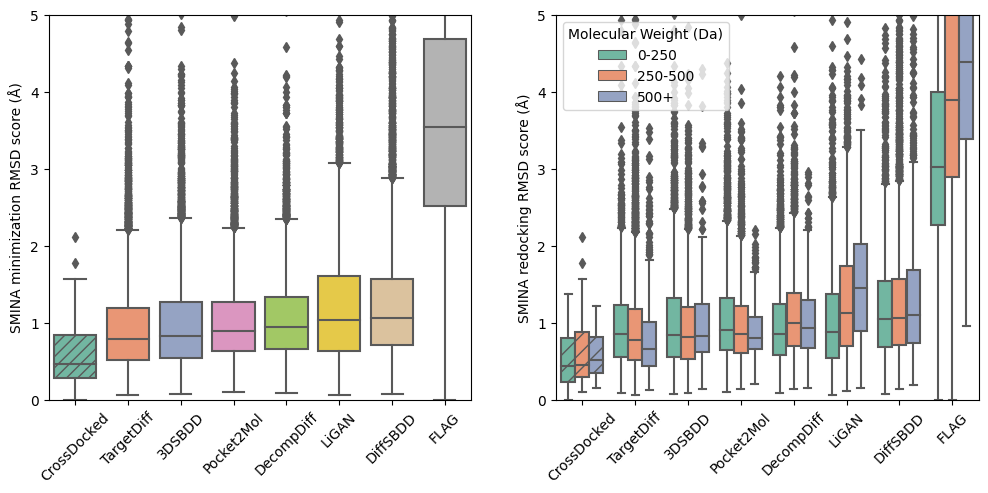

In [11]:
# order df by mean min_rmsd score
order = df.groupby('method').mean('min_rmsd').sort_values('min_rmsd').index
df['method'] = pd.Categorical(df['method'], order)

# 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# plt boxplot with mean min_rmsd score
boxes = sns.boxplot(data=df, x='method', y='min_rmsd',
                                #showmeans=True, meanprops={"marker":"o",},
                                palette='Set2', ax=ax1)
ax1.set_ylim(0, 5)
ax1.set_xticklabels(order_to_name(order), rotation=45)
ax1.set_xlabel('')
ax1.set_ylabel('SMINA minimization RMSD score (Å)')


boxes.patches[0].set_hatch('///')

df_copy = df.copy()

#split by bins
bins = [0, 250, 500, 1000]
labels = ['0-250', '250-500', '500+']
df_copy['Molecular Weight'] = pd.cut(df_copy['mw'], bins=bins, labels=labels, right=False)

# plt boxplot with mean min_rmsd score
boxes = sns.boxplot(data=df_copy, x='method', y='min_rmsd', hue='Molecular Weight', order=order,
            #showmeans=True, meanprops={"marker":"o",},
            palette='Set2', ax=ax2)

[boxes.patches[i].set_hatch('//') for i in [1,3,5]]


ax2.set_ylim(0, 5)
ax2.set_xticklabels(order_to_name(order), rotation=45)
ax2.set_xlabel('')
ax2.set_ylabel('SMINA redocking RMSD score (Å)')
ax2.legend(title='Molecular Weight (Da)', loc='upper left')

#### For paper

In [12]:
from functools import lru_cache

pdb_ids = ['2z3h', '4aaw', '4yhj', '14gs', '2v3r', '4rn0', '1fmc', '3daf', '1a2g',
    '5w2g', '3dzh', '3g51', '1coy', '2jjg', '2rhy', '2pqw', '4g3d', '5bur', '3gs6', '1r1h',
    '1dxo', '1gg5', '5q0k', '5b08', '2azy', '5i0b', '1phk', '4keu', '4q8b', '1djy', '5l1v',
    '4zfa', '2rma', '3b6h', '2zen', '4p6p', '3u5y', '4f1m', '4tqr', '4lfu', '3jyh', '4iwq',
    '1l3l', '5ngz', '1e8h', '2e24', '2hcj', '3kc1', '1d7j', '4ja8', '4u5s', '4iiy', '3v4t',
    '3tym', '4d7o', '3ej8', '1rs9', '4kcq', '3pdh', '1umd', '4pxz', '2gns', '1ai4', '5mma',
    '2cy0', '3w83', '2e6d', '4rv4', '5d7n', '5mgl', '1h36', '4gvd', '4tos', '5aeh', '4h3c',
    '4rlu', '4xli', '3l3n', '5tjn', '5liu', '3o96', '4qlk', '3hy9', '4bel', '3nfb', '4m7t',
    '3u9f', '4aua', '2f2c', '3chc', '1k9t', '1h0i', '4z2g', '3af2', '1jn2', '3li4', '3pnm',
    '1afs', '4azf', '2pc8']

@lru_cache(maxsize=128)
def fetch_classification(pdb_id):
    url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()['struct_keywords']
        return data
    else:
        print(f"Failed to fetch data for PDB ID {pdb_id}")
        return None

unaccounted = []

kinases = 0
gpcrs = 0
hydrolases = 0
transferases = 0
oxidoreductases = 0
transcription_factors = 0
membrane = 0 
isomerases = 0
ligases = 0
lyases = 0
viral = 0
transport = 0
signaling = 0

    
for pdb_id in pdb_ids:
    data = fetch_classification(pdb_id)
    keywords = data['pdbx_keywords']
    text = data['text']
    
    #print(keywords)
    #print(text)
    if 'kinase' in text.lower():
        kinases += 1
    elif 'gpcr' in text.lower():
        gpcrs += 1
    elif 'hydrolase' in keywords.lower() or 'hydrolase' in text.lower():
        hydrolases += 1
    elif 'transferase' in keywords.lower():
        transferases += 1
    elif 'oxidoreductase' in keywords.lower():
        oxidoreductases += 1
    elif 'transcription' in keywords.lower() or 'transcription' in text.lower():
        transcription_factors += 1
    elif 'membrane' in keywords.lower() or 'membrane' in text.lower():
        membrane += 1
    elif 'isomerase' in keywords.lower() or 'isomerase' in text.lower():
        isomerases += 1
    elif 'ligase' in keywords.lower() or 'ligase' in text.lower():
        ligases += 1
    elif 'lyase' in keywords.lower() or 'lyase' in text.lower():
        lyases += 1
    elif 'virus' in keywords.lower() or 'virus' in text.lower() or 'viral' in keywords.lower() or 'viral' in text.lower():
        viral += 1
    elif 'transport' in keywords.lower() or 'transport' in text.lower():
        transport += 1
    elif 'signaling' in keywords.lower() or 'signaling' in text.lower():
        signaling += 1
    
    else:
        unaccounted.append(data)
        print(pdb_id, data)
        
print('kinases', kinases)
print('gpcrs', gpcrs)
print('hydrolases', hydrolases)
print('transferases', transferases)
print('oxidoreductases', oxidoreductases)
print('transcription_factors', transcription_factors)
print('membrane', membrane)
print('isomerases', isomerases)
print('ligases', ligases)
print('lyases', lyases)
print('viral', viral)
print('transport', transport)
print('signaling', signaling)
        
print('unaccounted', len(unaccounted))

NameError: name 'requests' is not defined

In [13]:
import requests
from collections import Counter



# Sample list of PDB IDs
pdb_ids = ["1TUP", "1F88", "1XYZ"]

def fetch_classification(pdb_id):
    url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data["rcsb_entry_info"]["deposited_polymer_entity_instances"]
    else:
        print(f"Failed to fetch data for PDB ID {pdb_id}")
        return None

def main():
    # Counter to hold the number of occurrences of each protein classification
    classification_counter = Counter()

    for pdb_id in pdb_ids:
        classification = fetch_classification(pdb_id)
        if classification:
            classification_counter[classification] += 1

    print("Composition of the dataset:")
    for classification, count in classification_counter.items():
        print(f"{classification}: {count}")

if __name__ == "__main__":
    main()



KeyError: 'deposited_polymer_entity_instances'

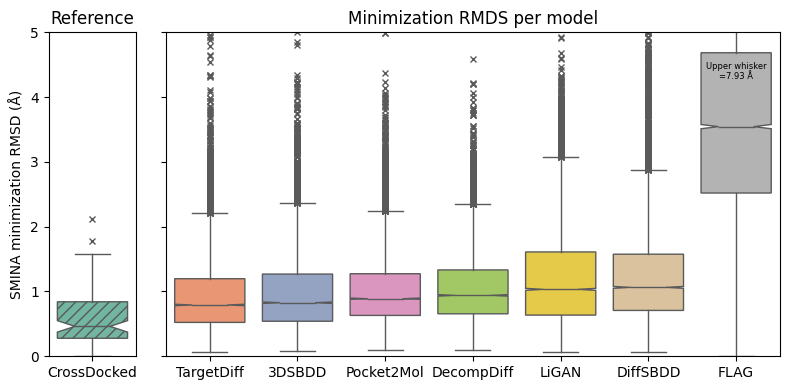

In [124]:
# order df by mean min_rmsd score
order = df.groupby('method').mean('min_rmsd').sort_values('min_rmsd').index
df['method'] = pd.Categorical(df['method'], order)

# 2 subplots
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(8, 4), sharey=True, gridspec_kw={"width_ratios": [1, 7]}
)

#ax1.add_patch(plt.Rectangle((-0.5, 0), 1, 10, facecolor='grey', alpha=0.5))

# plot crossdocked
boxes = sns.boxplot(data=df[df['method'] == 'crossdocked_test'],
            x='method', y='min_rmsd',
            #order='crossdocked_test',
            fliersize=5,
            notch=True,
            #order=order,
            linewidth=1,
            flierprops={"marker": "x"},
            palette='Set2', ax=ax1)

ax1.set_xlim(-0.5, 0.5)
ax1.set_ylabel('SMINA minimization RMSD (Å)')
ax1.set_xlabel('')
ax1.set_title('Reference')
ax1.set_xticklabels(['CrossDocked']*8)

boxes.patches[0].set_hatch('///')

ax1.set_ylim(0, 5)
#ax1.set_yscale('log')

        
# plt boxplot with mean min_rmsd score without crossdocked
boxes = sns.boxplot(data=df[df['method'] != 'crossdocked_test'], 
                    x='method', y='min_rmsd',
                        fliersize=5,
                        notch=True,
                        order=order[1:],
                        linewidth=1,
                        flierprops={"marker": "x"},
                            #showmeans=True, meanprops={"marker":"o",},
                            palette=sns.color_palette("Set2")[1:],
                            ax=ax2)

# plot FLAG upper whisker value as text
uq = df[df['method'] == 'flag']['min_rmsd'].describe()['75%']
lq = df[df['method'] == 'flag']['min_rmsd'].describe()['25%']
iqr = uq - lq
uw = uq + 1.5 * iqr


ax2.text(6, 4.4, 
        'Upper whisker\n=' + str(round(uw, 2)) + ' Å',
        horizontalalignment='center',
            verticalalignment='center', fontsize=6)

ax2.set_xticklabels(order_to_name(order[1:]), rotation=0)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Minimization RMDS per model')

# color in crossdocked area


plt.tight_layout()
plt.savefig('min_rmsd.svg')

#### Redocking RMSD

Text(0, 0.5, 'SMINA redocking RMSD score (Å)')

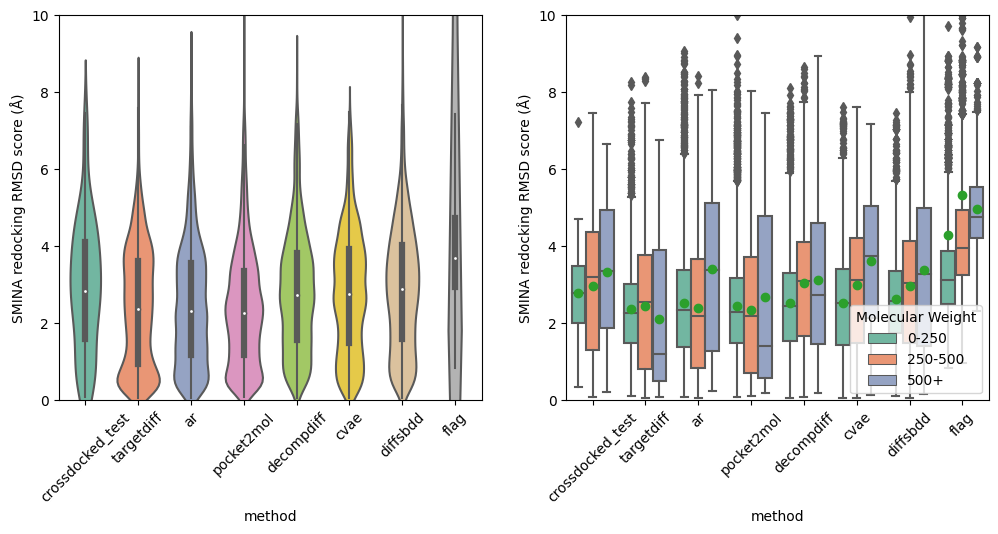

In [23]:
df_copy = df.copy()

# order df by mean min_rmsd score
order = df_copy.groupby('method').mean('redock_rmsd').sort_values('redock_rmsd').index
df_copy['method'] = pd.Categorical(df_copy['method'], order)

# 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# plt boxplot with mean min_rmsd score
sns.violinplot(data=df_copy, x='method', y='redock_rmsd', showmeans=True, meanprops={"marker":"o",}, palette='Set2', ax=ax1)
ax1.set_ylim(0, 10)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_ylabel('SMINA redocking RMSD score (Å)')


#split by bins
bins = [0, 250, 500, 1000]
labels = ['0-250', '250-500', '500+']
df_copy['Molecular Weight'] = pd.cut(df_copy['mw'], bins=bins, labels=labels, right=False)

# plt boxplot with mean min_rmsd score
sns.boxplot(data=df_copy, x='method', y='redock_rmsd', hue='Molecular Weight',
            showmeans=True, meanprops={"marker":"o",}, palette='Set2', ax=ax2)
ax2.set_ylim(0, 10)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_ylabel('SMINA redocking RMSD score (Å)')

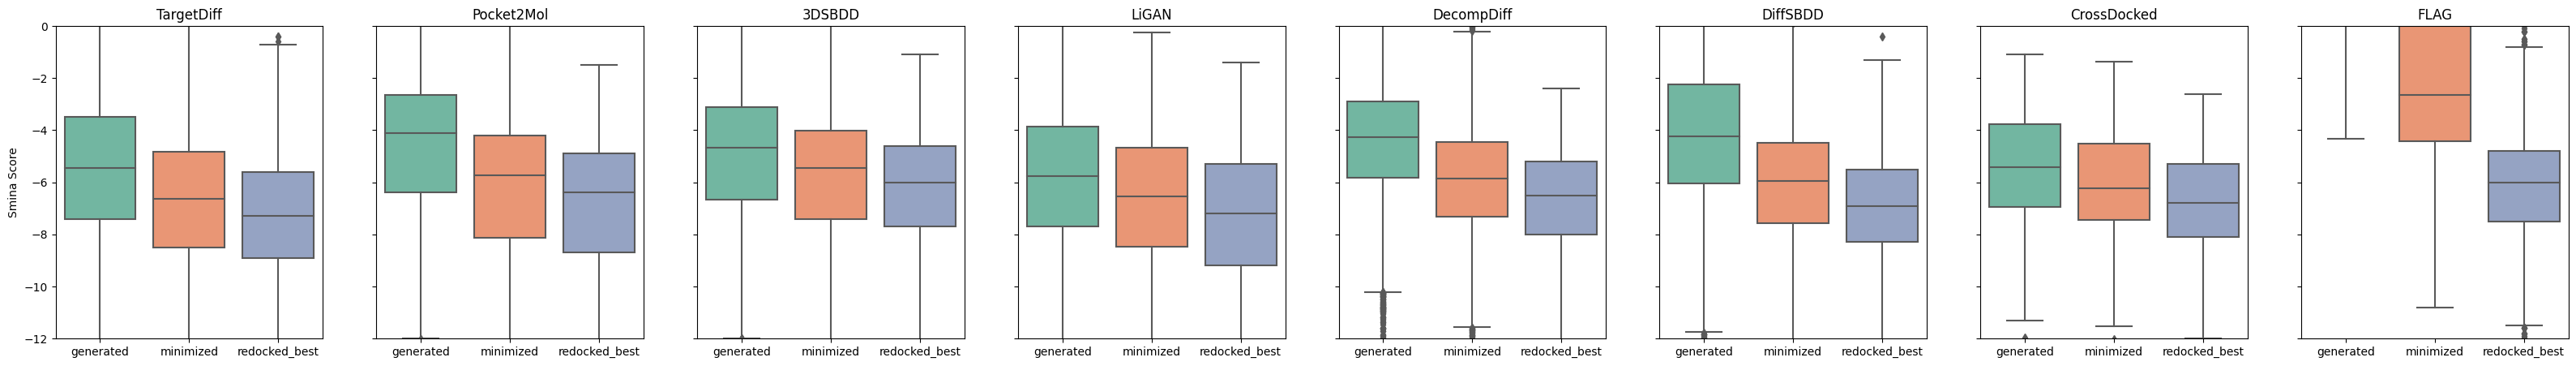

In [17]:
# drop relaxed_generated

models = df.method.unique()
models

fig, axs = plt.subplots(1, len(models), figsize=(len(models)*5, 5), sharey=True)

for i, model in enumerate(order):
    ax = axs[i]
    
    sns.boxplot(data=df[df.method == model], ax=ax, palette='Set2')
    #ax.set_xticklabels(['Generated', 'Minimized', 'Redocked\n(Best)', 'Relaxed +\nRedocked\n(Best)'], rotation=0)
    ax.set_title(names_dict[model])
    axs[0].set_ylabel('Smina Score')
    ax.set_ylim(-12, 0)
    ax.set_xlim(-0.5, 2.5)

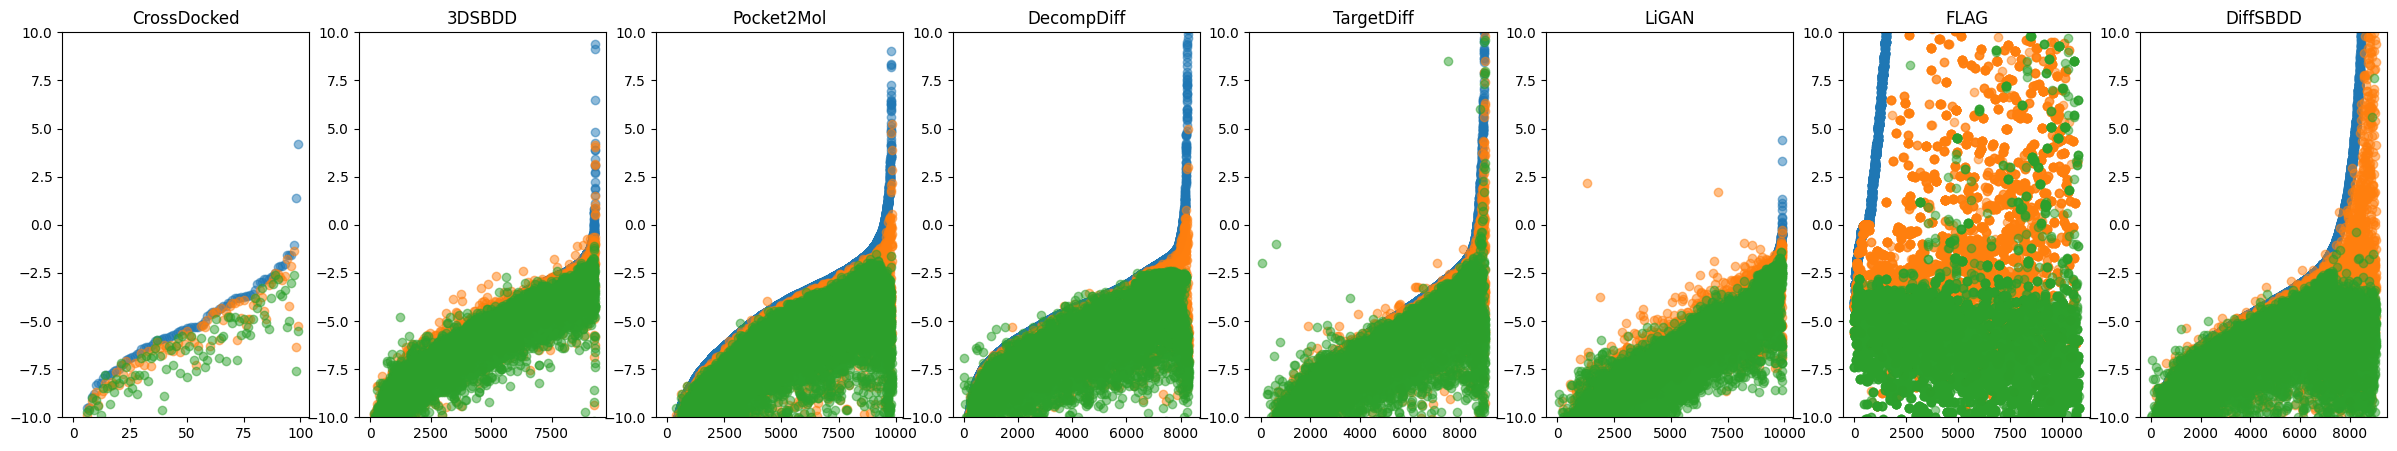

In [18]:
methods = df.method.unique().tolist()

# reorder to make crossdocked first
methods = ['crossdocked_test'] + [method for method in methods if method != 'crossdocked_test']

# plot affinities
fig, axs = plt.subplots(1, len(methods), figsize=(30, 5))

for method in methods:
    subset = df[df['method'] == method]
    ax = axs[methods.index(method)]

    # sort by generated affinity
    subset = subset.sort_values(by='generated')

    # plot affinties
    x = range(len(subset['generated']))
    ax.scatter(x, subset['generated'], alpha=0.5, label='Generated pose')
    ax.scatter(x, subset['minimized'], alpha=0.5, label='Minimized pose')
    ax.scatter(x, subset['redocked_best'], alpha=0.5, label='Redocked pose')
    ax.set_title(names_dict[method])

    #ax.legend()
    ax.set_ylim(-10, 10)

In [19]:
df.head()

,generated,minimized,redocked_best,redocked_all,generated_mol,minimized_mol,redocked_best_mol,redocked_all_mol,min_rmsd,target,method,redock_rmsd,mw
0,-2.14308,-2.59421,-2.9,"[-2.9, -2.9, -2.8, -2.7, -2.7, -2.7, -2.6, -2....",<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b04950>,<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b04a40>,<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b04ae0>,[<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b04a...,2.24844,2e24,ar,2.161890,86.090
1,-3.12254,-3.36024,-3.5,"[-3.5, -3.3, -3.3, -3.3, -3.2, -3.2, -3.2, -3....",<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b05080>,<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b05120>,<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b051c0>,[<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b051...,0.49183,2e24,ar,1.999054,86.134
2,-2.12935,-2.19994,-2.9,"[-2.9, -2.8, -2.8, -2.8, -2.7, -2.7, -2.7, -2....",<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b05760>,<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b057b0>,<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b05850>,[<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b058...,0.22356,2e24,ar,2.578173,88.106
3,-2.51772,-2.84351,-3.3,"[-3.3, -3.2, -3.1, -3.1, -3.0, -3.0, -3.0, -2....",<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b05df0>,<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b05e90>,<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b05f30>,[<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b05f...,0.65768,2e24,ar,2.559881,104.149
4,-3.59638,-4.08889,-4.1,"[-4.1, -4.1, -4.1, -3.7, -3.7, -3.7, -3.6, -3....",<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b06430>,<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b064d0>,<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b06570>,[<rdkit.Chem.rdchem.Mol object at 0x2ad9d3b065...,0.85446,2e24,ar,0.698477,98.145


### Minimise RMSD correlation

targetdiff            Gradient: -1.33 Å/kcal/mol Pearson: -0.4 p-value:  0.0
pocket2mol            Gradient: -1.38 Å/kcal/mol Pearson: -0.46 p-value:  0.0
ar                    Gradient: -0.27 Å/kcal/mol Pearson: -0.23 p-value:  4.727721851145675e-108
cvae                  Gradient: -0.17 Å/kcal/mol Pearson: -0.16 p-value:  1.557173577407235e-57
decompdiff            Gradient: -1.53 Å/kcal/mol Pearson: -0.4 p-value:  1.041614343e-315
diffsbdd              Gradient: -6.32 Å/kcal/mol Pearson: -0.63 p-value:  0.0
crossdocked_test      Gradient: -1.42 Å/kcal/mol Pearson: -0.49 p-value:  1.6598878823097097e-07
flag                  Gradient: -28.65 Å/kcal/mol Pearson: -0.59 p-value:  0.0


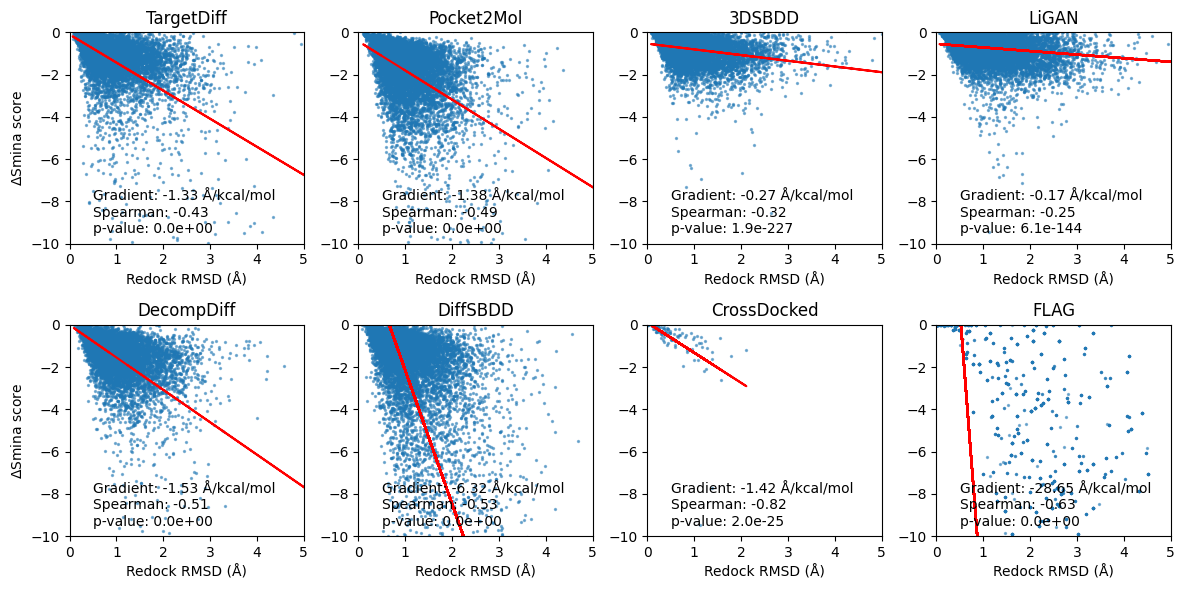

In [20]:
methods = order.to_list()

# Calculate rows and columns
n_methods = len(methods)
n_rows = 2
n_cols = (n_methods + 1) // 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6))

for i in range(n_rows):
    for j in range(n_cols):
        method_idx = i * n_cols + j
        if method_idx < n_methods:
            method = methods[method_idx]
            subset = df[df['method'] == method]
            
            ax = axs[i, j]

            redock_rmsd = subset['min_rmsd']
            delta_vina = subset['minimized'] - subset['generated']

            # remove nans
            nans_idx = np.isnan(delta_vina) + np.isnan(redock_rmsd)
            delta_vina = delta_vina[~nans_idx]
            redock_rmsd = redock_rmsd[~nans_idx]

            ax.scatter(redock_rmsd, delta_vina, alpha=0.5, s=2)
            ax.set_xlabel('Redock RMSD (Å)')
            
            if j == 0:
                ax.set_ylabel('$\Delta$Smina score')
                
            ax.set_ylim(-10, 0)
            ax.set_xlim(0, 5)
            ax.set_title(names_dict[method])

            # add line of best fit
            m, b = np.polyfit(redock_rmsd, delta_vina, 1)
            ax.plot(redock_rmsd, m*redock_rmsd + b, color='red')
            
            # add Spearman's r and p-value
            from scipy.stats import spearmanr
            spearman = spearmanr(redock_rmsd, delta_vina)
            p_value = spearman[1]    
            # Format the p-value for clarity
            if p_value < 0.0001:
                # standard form
                p_value_str = f"{p_value:.1e}"
            elif p_value < 0.01:
                p_value_str = f"= {p_value:.4f}"
            else:
                p_value_str = f"= {p_value:.2f}"
            
            ax.text(0.1, 0.05,
                    f'Gradient: {round(m, 2)} Å/kcal/mol\n' \
                    f'Spearman: {round(spearman[0], 2)}\np-value: {p_value_str}',
                    transform=ax.transAxes)

            # correlation coefficient with uncertainty and p-value print name and to 2 dp
            print(method, ' ' * (20 - len(method)),
                f'Gradient: {round(m, 2)} Å/kcal/mol ' 
                  f'Pearson:', round(pearsonr(redock_rmsd, delta_vina)[0], 2), 
                  'p-value: ', pearsonr(redock_rmsd, delta_vina)[1])

# If there are an odd number of methods, remove the unused axis
if n_methods % 2:
    fig.delaxes(axs[1, n_cols - 1])

plt.tight_layout()

### Full redocking

targetdiff            Gradient: -0.4 Å/kcal/mol Pearson: -0.26 p-value:  2.994240187711844e-131
pocket2mol            Gradient: -0.22 Å/kcal/mol Pearson: -0.18 p-value:  2.0805490212258005e-71
ar                    Gradient: -0.14 Å/kcal/mol Pearson: -0.22 p-value:  1.8597895812339566e-104
cvae                  Gradient: -0.22 Å/kcal/mol Pearson: -0.32 p-value:  3.633279660942036e-172
decompdiff            Gradient: -0.22 Å/kcal/mol Pearson: -0.14 p-value:  2.294280147211757e-28
diffsbdd              Gradient: -1.78 Å/kcal/mol Pearson: -0.3 p-value:  3.304339682406842e-183
crossdocked_test      Gradient: -0.13 Å/kcal/mol Pearson: -0.16 p-value:  0.11781197450175496
flag                  Gradient: 0.08 Å/kcal/mol Pearson: 0.02 p-value:  0.050386623470850773


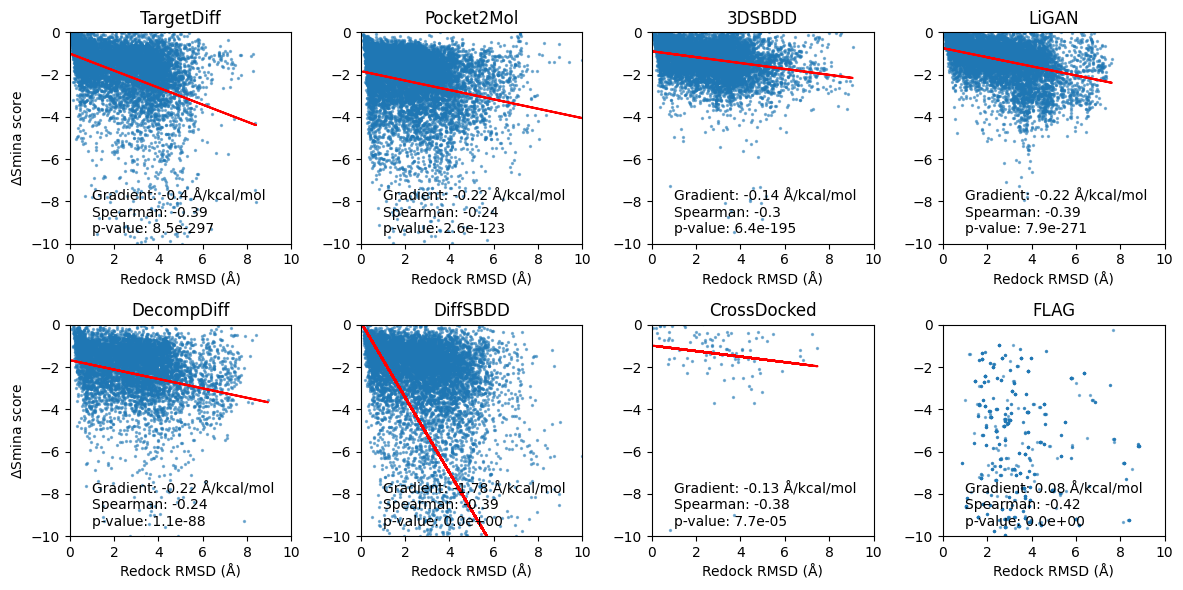

In [ ]:
methods = order.to_list()

# Calculate rows and columns
n_methods = len(methods)
n_rows = 2
n_cols = (n_methods + 1) // 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6))

for i in range(n_rows):
    for j in range(n_cols):
        method_idx = i * n_cols + j
        if method_idx < n_methods:
            method = methods[method_idx]
            subset = df[df['method'] == method]
            
            ax = axs[i, j]

            redock_rmsd = subset['redock_rmsd']
            delta_vina = subset['redocked_best'] - subset['generated']

            # remove nans
            nans_idx = np.isnan(delta_vina) + np.isnan(redock_rmsd)
            delta_vina = delta_vina[~nans_idx]
            redock_rmsd = redock_rmsd[~nans_idx]

            ax.scatter(redock_rmsd, delta_vina, alpha=0.5, s=2)
            ax.set_xlabel('Redock RMSD (Å)')
            
            if j == 0:
                ax.set_ylabel('$\Delta$Smina score')
                
            ax.set_ylim(-10, 0)
            ax.set_xlim(0, 10)
            ax.set_title(names_dict[method])

            # add line of best fit
            m, b = np.polyfit(redock_rmsd, delta_vina, 1)
            ax.plot(redock_rmsd, m*redock_rmsd + b, color='red')
            
            # add Spearman's r and p-value
            from scipy.stats import spearmanr
            spearman = spearmanr(redock_rmsd, delta_vina)
            p_value = spearman[1]    
            # Format the p-value for clarity
            if p_value < 0.0001:
                # standard form
                p_value_str = f"{p_value:.1e}"
            elif p_value < 0.01:
                p_value_str = f"= {p_value:.4f}"
            else:
                p_value_str = f"= {p_value:.2f}"
            
            ax.text(0.1, 0.05,
                    f'Gradient: {round(m, 2)} Å/kcal/mol\n' \
                    f'Spearman: {round(spearman[0], 2)}\np-value: {p_value_str}',
                    transform=ax.transAxes)

            # correlation coefficient with uncertainty and p-value print name and to 2 dp
            print(method, ' ' * (20 - len(method)),
                f'Gradient: {round(m, 2)} Å/kcal/mol ' 
                  f'Pearson:', round(pearsonr(redock_rmsd, delta_vina)[0], 2), 
                  'p-value: ', pearsonr(redock_rmsd, delta_vina)[1])

# If there are an odd number of methods, remove the unused axis
if n_methods % 2:
    fig.delaxes(axs[1, n_cols - 1])

plt.tight_layout()

#### RMSD to closest pose

In [21]:
generated_mols = df.generated_mol.values
redocked_mols = df.redocked_all_mol.values

In [22]:
len(generated_mols), len(redocked_mols)

# apply create nested list of all rmsd values
rmsd_values = [[rmsd(generated_mol, redocked_pose) for redocked_pose in redocked_poses] for generated_mol, redocked_poses in zip(generated_mols, redocked_mols)]

In [36]:
df['all_redock_rmsds'] = rmsd_values
df['closest_redock_rmsds'] = [min(rmsd_values) for rmsd_values in df.all_redock_rmsds]
min_idx = [rmsd_values.index(min(rmsd_values)) for rmsd_values in df.all_redock_rmsds]

df['closest_vina_score'] =  [scores[idx] for scores, idx in zip(df.redocked_all, min_idx)]   

(0.0, 10.0)

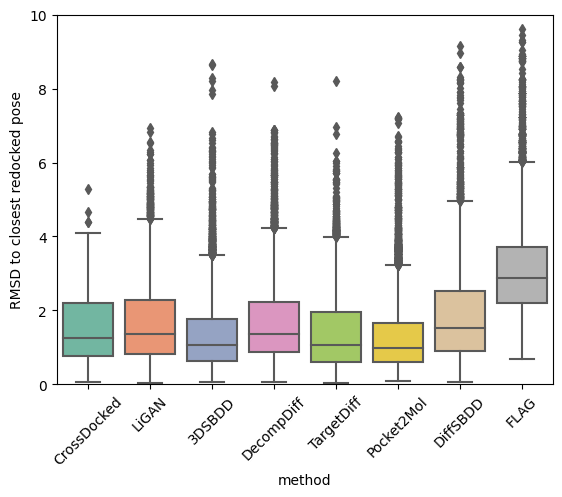

In [38]:
sns.boxplot(df, x='method', y='closest_redock_rmsds',
            order=order,
            #hue='mw',
            palette='Set2',
            )

plt.ylabel('RMSD to closest redocked pose')
plt.xticks(range(len(order)), order_to_name(order), rotation=45)
plt.ylim(0, 10)

## Change in affinity

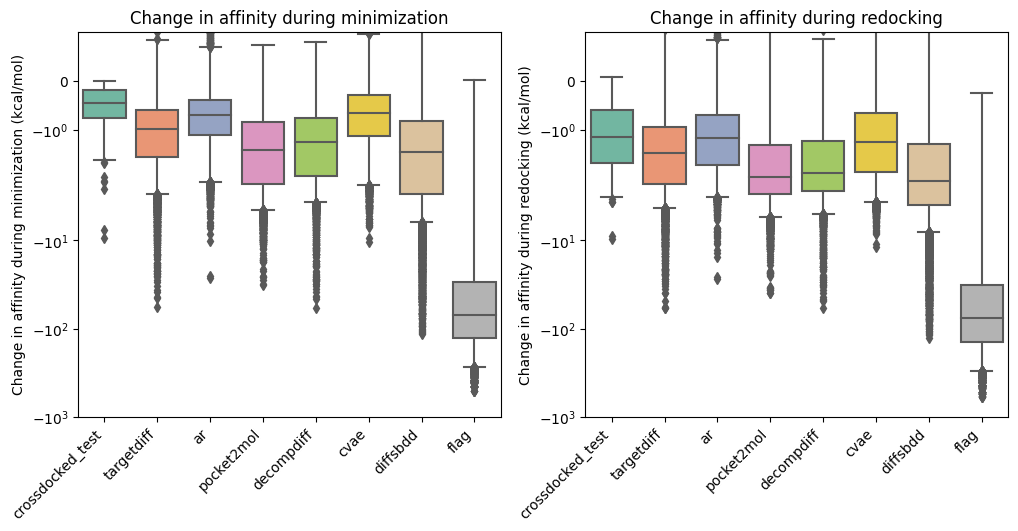

In [30]:
# Calculate the changes in affintyires between the generated, minized and redocked poses

delta_minimized = df.minimized - df.generated
delta_redocked = df.redocked_best - df.generated

delta_minimized_redocked = df.redocked_best - df.minimized

df['delta_minimized'] = delta_minimized
df['delta_redocked'] = delta_redocked

df['delta_minimized_redocked'] = delta_minimized_redocked

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=df, x='method', y='delta_minimized', palette='Set2', ax=ax1)
ax1.set_ylabel('Change in affinity during minimization (kcal/mol)')
ax1.set_title('Change in affinity during minimization')

sns.boxplot(data=df, x='method', y='delta_redocked', palette='Set2', ax=ax2)
ax2.set_ylabel('Change in affinity during redocking (kcal/mol)')
ax2.set_title('Change in affinity during redocking')


for ax in (ax1, ax2):
    ax.set_xlabel('')
    #ax.set_xticklabels(order_to_name(order), rotation=45, ha='right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yscale('symlog')
    ax.set_ylim(-1000, 1)

### Table

In [31]:
# calculate amount of redocking rmsd per delta affinity
df['rmsd_per_delta_affinity_redocking'] = df.redock_rmsd / df.delta_redocked

# ignore inf values and nans
df['rmsd_per_delta_affinity_minimization'] = (df.min_rmsd / df.delta_minimized).replace([np.inf, -np.inf], np.nan)

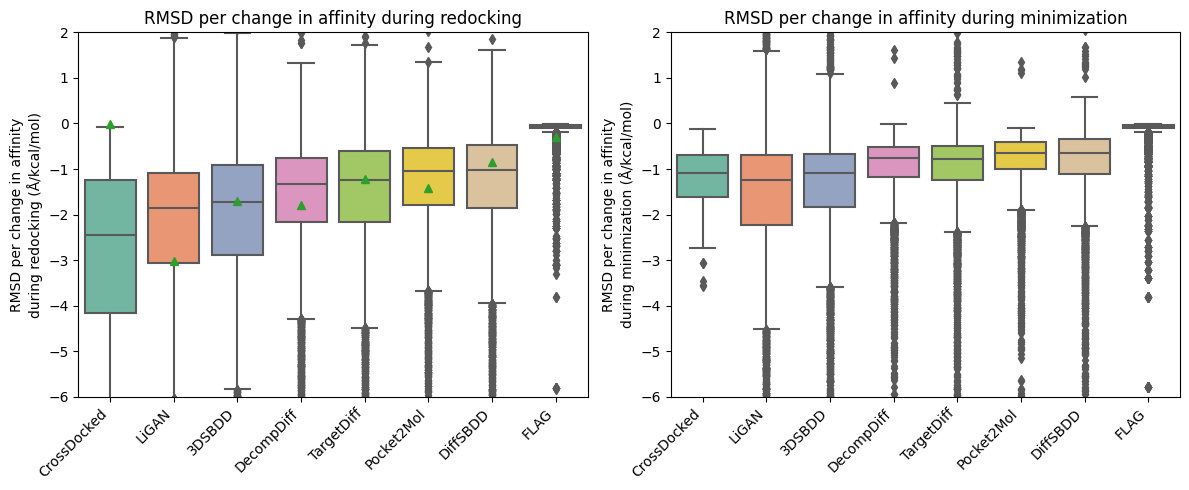

In [35]:
# plot boxplot for rmsd per delta affinity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

order = df.groupby('method').median('rmsd_per_delta_affinity_redocking')['rmsd_per_delta_affinity_redocking'].sort_values(ascending=True).index

sns.boxplot(data=df, x='method', y='rmsd_per_delta_affinity_redocking', palette='Set2', ax=ax1, order=order,
            #meanline=True,
            showmeans=True)
ax1.set_ylabel('RMSD per change in affinity\nduring redocking (Å/kcal/mol)')
ax1.set_title('RMSD per change in affinity during redocking')

sns.boxplot(data=df, x='method', y='rmsd_per_delta_affinity_minimization', palette='Set2', ax=ax2, order=order)
ax2.set_ylabel('RMSD per change in affinity\nduring minimization (Å/kcal/mol)')
ax2.set_title('RMSD per change in affinity during minimization')

for ax in (ax1, ax2):
    ax.set_xlabel('')
    ax.set_xticklabels(order_to_name(order), rotation=45, ha='right')
    #ax.set_yscale('symlog')
    ax.set_ylim(-6, 2)

fig.tight_layout()

In [ ]:
#print out the mean and std of the redocked, minimized, and generated scores for each method in latex format

generated_scores = df.groupby('method').describe()['generated']
minimized_scores = df.groupby('method').describe()['minimized']
redocking_scores = df.groupby('method').describe()['redocked_best']

delta_minimized_scores = df.groupby('method').describe()['delta_minimized']
delta_redocking_scores = df.groupby('method').describe()['delta_redocked']

rmsd_per_delta_affinity_redocking = df.groupby('method').describe()['rmsd_per_delta_affinity_redocking']

# bold headers
print('\\textbf{Method} & \\textbf{Generated} & \\textbf{Minimized} & \\textbf{Redocked} & \\textbf{$\Delta$Minimized} & \\textbf{$\Delta$Redocked} & \\textbf{RMSD/$\Delta$Redocked} \\\\')
print('\midrule')

# print with equal spacing regardless of length of method name and round to 2 decimal places and align on decimal
for method in generated_scores.index:
    #print(names_dict[method], '&', round(generated_scores.loc[method]['mean'], 2), '$\pm$', round(generated_scores.loc[method]['std'], 2), '&', round(minimized_scores.loc[method]['mean'], 2), '$\pm$', round(minimized_scores.loc[method]['std'], 2), '&', round(redocking_scores.loc[method]['mean'], 2), '$\pm$', round(redocking_scores.loc[method]['std'], 2), '\\\\')
    name = names_dict[method]
    print(name + ' ' * (15-len(name)), '&',
          round(generated_scores.loc[method]['mean'], 2), '$\pm$', round(generated_scores.loc[method]['std'], 2), '&',
          round(minimized_scores.loc[method]['mean'], 2), '$\pm$', round(minimized_scores.loc[method]['std'], 2), '&',
          round(redocking_scores.loc[method]['mean'], 2), '$\pm$', round(redocking_scores.loc[method]['std'], 2), '&',
          
          round(delta_minimized_scores.loc[method]['mean'], 2), '$\pm$', round(delta_minimized_scores.loc[method]['std'], 2), '&',
        round(delta_redocking_scores.loc[method]['mean'], 2), '$\pm$', round(delta_redocking_scores.loc[method]['std'], 2), '&',
        round(rmsd_per_delta_affinity_redocking.loc[method]['mean'], 2), '$\pm$', round(rmsd_per_delta_affinity_redocking.loc[method]['std'], 2), '\\\\')
        
    if method == 'crossdocked_test':
        print('\midrule')

\textbf{Method} & \textbf{Generated} & \textbf{Minimized} & \textbf{Redocked} & \textbf{$\Delta$Minimized} & \textbf{$\Delta$Redocked} & \textbf{RMSD/$\Delta$Redocked} \\
\midrule
CrossDocked     & -5.5 $\pm$ 2.86 & -6.24 $\pm$ 2.52 & -6.86 $\pm$ 2.37 & -0.74 $\pm$ 1.24 & -1.37 $\pm$ 1.43 & -0.0 $\pm$ 26.62 \\
\midrule
TargetDiff      & -5.36 $\pm$ 3.79 & -6.72 $\pm$ 2.83 & -7.35 $\pm$ 2.51 & -1.35 $\pm$ 1.99 & -1.99 $\pm$ 2.59 & -1.23 $\pm$ 53.43 \\
3DSBDD          & -5.04 $\pm$ 2.58 & -5.85 $\pm$ 2.42 & -6.29 $\pm$ 2.22 & -0.8 $\pm$ 0.76 & -1.25 $\pm$ 1.0 & -1.69 $\pm$ 70.84 \\
Pocket2Mol      & -4.55 $\pm$ 3.18 & -6.38 $\pm$ 2.92 & -6.96 $\pm$ 2.72 & -1.83 $\pm$ 1.66 & -2.4 $\pm$ 2.01 & -1.42 $\pm$ 5.72 \\
DecompDiff      & -4.25 $\pm$ 3.16 & -5.91 $\pm$ 2.14 & -6.56 $\pm$ 2.03 & -1.66 $\pm$ 2.39 & -2.31 $\pm$ 2.69 & -1.79 $\pm$ 13.21 \\
LiGAN           & -6.03 $\pm$ 2.83 & -6.78 $\pm$ 2.71 & -7.36 $\pm$ 2.56 & -0.75 $\pm$ 0.78 & -1.34 $\pm$ 1.09 & -3.05 $\pm$ 35.37 \\
DiffSBDD     

### Change in affinity to closet pose 

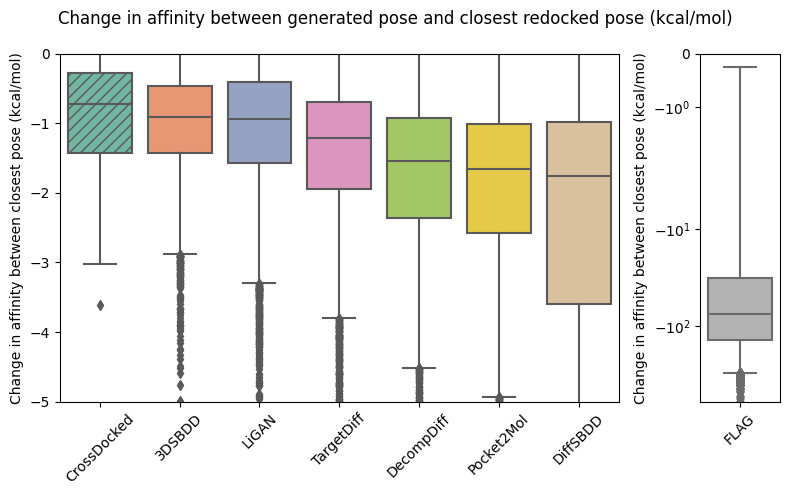

In [ ]:
# change in affinty between closest and generated poses
change = df.closest_vina_score - df.generated 

# molcular weight of ligands
mw = [Descriptors.MolWt(mol) if mol is not None else None for mol in df.generated_mol]

closest_df = pd.DataFrame({'change': change,
                            'closest': df.closest_redock_rmsds,
                            'molecular_weight': mw,
                            'method': df.method})

# num boxplot ratio 7:1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), 
                                 gridspec_kw={'width_ratios': [7, 1]})

# order by change 
order = closest_df.groupby('method').median().sort_values('change', ascending=False).index
closest_df['method'] = pd.Categorical(closest_df['method'], order)

# plot change in affinity without FLAG
boxes = sns.boxplot(x='method', y='change', data=closest_df[closest_df.method != 'flag'],
            order=order.to_list()[:-1],
               # texture the crossdocked test boxplot only
               palette='Set2', ax=ax1)

ax1.set_ylim(-5, 0)
ax1.set_ylabel('Change in affinity between closest pose (kcal/mol)')
ax1.set_xlabel('')
    
boxes.patches[0].set_hatch('///')

# set xticklabels
ax1.set_xticklabels(order_to_name(order.to_list()[:-1]), rotation=45, ha='center')

# plot change in affinity with FLAG on its own scale
sns.boxplot(x='method', y='change', data=closest_df[closest_df.method == 'flag'],
            order=order.to_list()[-1:],
            # set color to last color in palette
            color=sns.color_palette('Set2')[len(order.to_list())-1],
            ax=ax2)

ax2.set_xticklabels(order_to_name(order.to_list()[-1:]), rotation=45, ha='center')
ax2.set_xlabel('')
ax2.set_ylabel('Change in affinity between closest pose (kcal/mol)')
ax2.set_ylim(-600, 0)
ax2.set_yscale('symlog')

# Fig title
fig.suptitle('Change in affinity between generated pose and closest redocked pose (kcal/mol)')

fig.tight_layout()

(-14.0, 2.0)

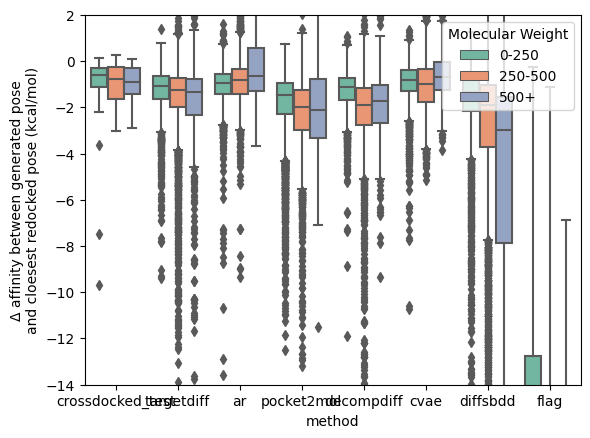

In [ ]:
bins = [0, 250, 500, 1000]
labels = ['0-250', '250-500', '500+']
closest_df['Molecular Weight'] = pd.cut(closest_df['molecular_weight'], bins=bins, labels=labels, right=False)

sns.boxplot(x='method', y='change', data=closest_df,
               #width=1, linewidth=1,
               hue='Molecular Weight',
               palette='Set2')

#plt.ylim(-6, 2)
plt.ylabel('Δ affinity between generated pose\nand cloesest redocked pose (kcal/mol)')
plt.ylim(-14, 2)